In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Lambda, Add, concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import os
import gc
from pathlib import Path

from pure_pursuit import *
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

2024-02-29 23:47:20.971343: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-29 23:47:21.001786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 23:47:21.444248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-02-29 23:47:22.285083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 23:47:22.290022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 23:47:22.290157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
MODEL_SAVE_DIR = Path("PI_model_new_tests")
if not MODEL_SAVE_DIR.exists():
    os.makedirs(MODEL_SAVE_DIR.as_posix())

### Loading data files

In [4]:
def get_data_files(path="../../torcs_SL/data_all/data", pick_train=None, pick_test=None):
    train_files = []
    val_files = []

    path = Path(path)
    tracks = os.listdir(path.as_posix())

    train_tracks = ['g-track-1', 'g-track-2', 'g-track-3', 'g-track-4', 'spring', 'aalborg', 'wheel-1', 'wheel-2', 'e-track-1', 'e-track-2']
    test_tracks = ['e-track-3', 'alpine-2', 'corkscrew', 'wheel-2','ruudskogen']

    random_tracks = np.random.choice(tracks, len(tracks), replace=False)
    random_tracks = [x for x in random_tracks if x[:4] != 'dirt' and x[:3] != 'mix' and x not in test_tracks and x not in train_tracks]

    val_tracks = test_tracks # random_tracks#[:3]
    #train_tracks.extend(random_tracks[:18])

    track_files = list(path.glob("**/*.csv"))


    train_track_files = [x for x in track_files if x.parts[-2] in train_tracks]
    val_track_files = [x for x in track_files if x.parts[-2] in val_tracks]
    
    
    train_track_files = np.random.choice(train_track_files, pick_train, replace=False) if pick_train else train_track_files
    val_track_files = np.random.choice(val_track_files, pick_test, replace=False) if pick_test else val_track_files

    return train_track_files, val_track_files

In [5]:
empty_train_track_files, empty_val_track_files = get_data_files(path="../../torcs_SL/data_all/data")
empty_train_track_files, empty_val_track_files

([PosixPath('../../torcs_SL/data_all/data/g-track-2/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-2/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-2/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/aalborg/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/aalborg/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/aalborg/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/wheel-1/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/wheel-1/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/wheel-1/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-1/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-1/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-1/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-3/2.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-3/3.csv'),
  PosixPath('../../torcs_SL/data_all/data/g-track-3/1.csv'),
  PosixPath('../../torcs_SL/data_all/data/wheel-2/2.csv'),
  PosixPath('../../torcs_SL/data_all/d

In [6]:
traffic_train_track_files, traffic_val_track_files = get_data_files("../../torcs_SL/TORCS_DATA/data", 25, 12)
traffic_train_track_files, traffic_val_track_files

(array([PosixPath('../../torcs_SL/TORCS_DATA/data/wheel-2/24.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/g-track-2/5.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/wheel-2/22.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/spring/7.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/wheel-2/19.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/g-track-2/3.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/wheel-2/11.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/spring/16.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/g-track-3/26.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/g-track-2/7.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/wheel-2/4.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/spring/3.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/g-track-2/23.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/data/wheel-2/16.csv'),
        PosixPath('../../torcs_SL/TORCS_DATA/da

### Train-Test Split

In [7]:
empty_training_data = pd.DataFrame()
empty_validation_data = pd.DataFrame()
split_ratio = 0.8

for fi in empty_train_track_files:
    empty_training_data = pd.concat([empty_training_data, pd.read_csv(fi)]).reset_index(drop=True)

for fi in empty_val_track_files:

    empty_validation_data = pd.concat([empty_validation_data, pd.read_csv(fi)]).reset_index(drop=True)

print (empty_training_data.shape)
print (empty_training_data.shape)

(170501, 79)
(170501, 79)


In [8]:
traffic_training_data = pd.DataFrame()
traffic_validation_data = pd.DataFrame()
split_ratio = 0.8

for fi in traffic_train_track_files:
    traffic_training_data = pd.concat([traffic_training_data, pd.read_csv(fi)]).reset_index(drop=True)

for fi in traffic_val_track_files:

    traffic_validation_data = pd.concat([traffic_validation_data, pd.read_csv(fi)]).reset_index(drop=True)
    
print (traffic_training_data.shape)
print (traffic_validation_data.shape)

(509017, 79)
(171832, 79)


In [9]:
class PurePursuit:
    
    @staticmethod
    def get_max_dist(track):
        track_dists = np.array(track)
        return np.max(track_dists)
    
    @staticmethod
    def get_max_dist_idx(track):
        track_dists = np.array(track)
        if track_dists[9] == np.max(track_dists) or track_dists[9] == 200:
            return 9
        return np.argmax(track_dists)
    
    @staticmethod
    def compute_target_angle(track):

        max_track_dist_idx = PurePursuit.get_max_dist_idx(track)

        max_dist_angle = max_track_dist_idx * 10. - 90.
        return max_dist_angle 
    
    @staticmethod
    def get_lookahead(track):
        max_track_dist_idx = PurePursuit.get_max_dist_idx(track)
        return track[max_track_dist_idx]

In [10]:
def process_training_data(training_data, validation_data):
    del training_data['Gear']
    del validation_data['Gear']
    del training_data[' CurrentLapTime']
    del validation_data[' CurrentLapTime']
    del training_data[' LastLapTime']
    del validation_data[' LastLapTime']
    del training_data[' Damage']
    del validation_data[' Damage']
    del training_data[' FuelLevel']
    del validation_data[' FuelLevel']

    del training_data[' DistanceFromStart']
    del validation_data[' DistanceFromStart']
    

    # for col in [c for c in training_data.columns if c.strip()[:3] == "Opp"]:
    #     del training_data[col]
    #     del validation_data[col]
    
    training_data['target_angle'] = training_data.iloc[:, 8+36: 27+36].apply(lambda x : PurePursuit.compute_target_angle(x.values), axis=1)
    validation_data['target_angle'] = validation_data.iloc[:, 8+36: 27+36].apply(lambda x : PurePursuit.compute_target_angle(x.values), axis=1)

    training_data['lookahead'] = training_data.iloc[:, 8+36: 27+36].apply(lambda x : PurePursuit.get_lookahead(x.values), axis=1)
    validation_data['lookahead'] = validation_data.iloc[:, 8+36: 27+36].apply(lambda x : PurePursuit.get_lookahead(x.values), axis=1)
    
    X_train=training_data.loc[:,[' Opponent_1', 'Opponent_2',
       'Opponent_3', 'Opponent_4', 'Opponent_5', 'Opponent_6', 'Opponent_7',
       'Opponent_8', 'Opponent_9', 'Opponent_10', 'Opponent_11', 'Opponent_12',
       'Opponent_13', 'Opponent_14', 'Opponent_15', 'Opponent_16',
       'Opponent_17', 'Opponent_18', 'Opponent_19', 'Opponent_20',
       'Opponent_21', 'Opponent_22', 'Opponent_23', 'Opponent_24',
       'Opponent_25', 'Opponent_26', 'Opponent_27', 'Opponent_28',
       'Opponent_29', 'Opponent_30', 'Opponent_31', 'Opponent_32',
       'Opponent_33', 'Opponent_34', 'Opponent_35', 'Opponent_36', ' Track_1',
       'Track_2', 'Track_3', 'Track_4', 'Track_5', 'Track_6', 'Track_7',
       'Track_8', 'Track_9', 'Track_10', 'Track_11', 'Track_12', 'Track_13',
       'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18', 'Track_19', 
        'TrackPosition', 'Angle', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ',
        ' WheelSpinVelocity_1', 'WheelSpinVelocity_2',
       'WheelSpinVelocity_3', 'WheelSpinVelocity_4', 'target_angle', 'lookahead']]

    Y_train=training_data.loc[:,'Steering']
    X_val=validation_data.loc[:,[' Opponent_1', 'Opponent_2',
           'Opponent_3', 'Opponent_4', 'Opponent_5', 'Opponent_6', 'Opponent_7',
           'Opponent_8', 'Opponent_9', 'Opponent_10', 'Opponent_11', 'Opponent_12',
           'Opponent_13', 'Opponent_14', 'Opponent_15', 'Opponent_16',
           'Opponent_17', 'Opponent_18', 'Opponent_19', 'Opponent_20',
           'Opponent_21', 'Opponent_22', 'Opponent_23', 'Opponent_24',
           'Opponent_25', 'Opponent_26', 'Opponent_27', 'Opponent_28',
           'Opponent_29', 'Opponent_30', 'Opponent_31', 'Opponent_32',
           'Opponent_33', 'Opponent_34', 'Opponent_35', 'Opponent_36', ' Track_1',
           'Track_2', 'Track_3', 'Track_4', 'Track_5', 'Track_6', 'Track_7',
           'Track_8', 'Track_9', 'Track_10', 'Track_11', 'Track_12', 'Track_13',
           'Track_14', 'Track_15', 'Track_16', 'Track_17', 'Track_18', 'Track_19', 
            'TrackPosition', 'Angle', ' RPM', ' SpeedX', ' SpeedY', ' SpeedZ',
            ' WheelSpinVelocity_1', 'WheelSpinVelocity_2',
           'WheelSpinVelocity_3', 'WheelSpinVelocity_4', 'target_angle', 'lookahead']]
    Y_val=validation_data.loc[:,'Steering']
    
    return X_train, X_val, Y_train, Y_val
    
    

In [11]:
X_train_empty, X_val_empty, Y_train_empty, Y_val_empty = process_training_data(empty_training_data, empty_validation_data)

In [12]:
X_train_traffic, X_val_traffic, Y_train_traffic, Y_val_traffic = process_training_data(traffic_training_data, traffic_validation_data)

## PI Model Training

In [13]:
print (X_train_empty.shape)
print (Y_train_empty.shape)
print (X_val_empty.shape)
print (Y_val_empty.shape)
scaler = StandardScaler()

scaler.fit(pd.concat([X_train_empty.iloc[:, :-2], X_train_traffic.iloc[:, :-2]]))


X_train_empty.iloc[:, :-2]=scaler.transform(X_train_empty.iloc[:, :-2])
X_val_empty.iloc[:, :-2]=scaler.transform(X_val_empty.iloc[:, :-2])


Y_train_empty=Y_train_empty.values
Y_val_empty=Y_val_empty.values
print (X_train_empty.shape)
print (Y_train_empty.shape)
print (X_val_empty.shape)
print (Y_val_empty.shape)

(170501, 67)
(170501,)
(121802, 67)
(121802,)
(170501, 67)
(170501,)
(121802, 67)
(121802,)


### Save these means and stds for test time

In [14]:
with open(MODEL_SAVE_DIR.joinpath("scaler.pickle").as_posix(), "wb") as fp:
    pickle.dump(scaler, fp)

In [15]:
scaler.mean_

array([ 1.83227962e+02,  1.92360641e+02,  1.95010964e+02,  1.97149688e+02,
        1.98147147e+02,  1.98668669e+02,  1.98778319e+02,  1.99091118e+02,
        1.99228958e+02,  1.99277584e+02,  1.99256882e+02,  1.99162954e+02,
        1.98878682e+02,  1.98619363e+02,  1.98034641e+02,  1.96736483e+02,
        1.94857875e+02,  1.87939755e+02,  1.88703480e+02,  1.93616410e+02,
        1.96357589e+02,  1.97838887e+02,  1.98696840e+02,  1.98968456e+02,
        1.99067970e+02,  1.99320870e+02,  1.99275152e+02,  1.99246620e+02,
        1.99143285e+02,  1.98918903e+02,  1.98516066e+02,  1.97888511e+02,
        1.96624508e+02,  1.93568465e+02,  1.88435871e+02,  1.80931956e+02,
        5.89803483e+00,  6.06579731e+00,  7.54813490e+00,  1.00917032e+01,
        1.83778550e+01,  2.43166968e+01,  3.53370090e+01,  6.21191699e+01,
        7.78454459e+01,  7.81027612e+01,  7.76184473e+01,  6.48149819e+01,
        4.23094996e+01,  2.52759198e+01,  1.95239248e+01,  1.18487881e+01,
        9.02083326e+00,  

In [16]:
scaler.scale_

array([4.75448017e+01, 3.27213371e+01, 2.57145844e+01, 1.86594352e+01,
       1.48707156e+01, 1.28154486e+01, 1.25439681e+01, 1.05105153e+01,
       9.48797794e+00, 9.19113890e+00, 9.52957788e+00, 1.02328688e+01,
       1.18620964e+01, 1.29380807e+01, 1.54649778e+01, 2.04431941e+01,
       2.66806968e+01, 4.06349905e+01, 3.91659905e+01, 2.99175913e+01,
       2.27866640e+01, 1.69366444e+01, 1.30300353e+01, 1.13399971e+01,
       1.10125438e+01, 9.11181920e+00, 9.62284466e+00, 9.80939537e+00,
       1.04959322e+01, 1.15745587e+01, 1.36876063e+01, 1.65489778e+01,
       2.15005816e+01, 2.97856399e+01, 4.04747161e+01, 5.07895987e+01,
       4.71371113e+00, 4.71663623e+00, 5.47548580e+00, 7.20802552e+00,
       1.76012898e+01, 2.01453683e+01, 2.39275693e+01, 4.18044167e+01,
       5.57672178e+01, 5.45940702e+01, 5.36359692e+01, 4.17018095e+01,
       3.02674133e+01, 1.53475823e+01, 1.22092567e+01, 7.38152151e+00,
       6.03494672e+00, 5.24898052e+00, 5.30396929e+00, 5.20081484e-01,
      

In [17]:
np.save(MODEL_SAVE_DIR.joinpath("means.npy"), scaler.mean_)
np.save(MODEL_SAVE_DIR.joinpath("stds.npy"), scaler.scale_)

In [18]:
@tf.function
def get_max_dist(track_dists):
    return tf.reduce_max(track_dists, axis=1)

@tf.function
def get_max_dist_idx(track_dists):
    mask = track_dists[:, 9] != 200
    mask = tf.cast(mask, tf.int32)
    indices = tf.math.argmax(track_dists, output_type=tf.int32, axis=1)
    arr1 = indices * mask
    additional = tf.cast(track_dists[:, 9] == 200, tf.int32) * 9
    result = arr1 + additional
    
    return result

@tf.function
def compute_target_angle(track_dists):

    max_track_dist_idx = get_max_dist_idx(track_dists)

    max_dist_angle = max_track_dist_idx * 10 - 90
    return tf.cast(max_dist_angle, tf.float32) * RAD_PER_DEG

@tf.function
def compute_target_angle_2(angle_probs):

    max_track_dist_idx = tf.math.argmax(angle_probs, output_type=tf.int32, axis=1)

    max_dist_angle = max_track_dist_idx * 10 - 90
    return tf.cast(max_dist_angle, tf.float32) * RAD_PER_DEG

In [19]:
@tf.function
def is_off_track(trackPos, angle):
    return tf.abs(trackPos) > 1.0 and tf.abs(angle) > PI_HALF

In [20]:
@tf.function
def compute_steering(data):

    target_angle = data[:, 0] * RAD_PER_DEG
    lookahead = data[:, 1]


    raw_steering_angle_rad = -tf.math.atan(
        (PURE_PURSUIT_2L * tf.math.sin(target_angle)) / (lookahead + 1e-7))

    raw_steering_angle_deg = raw_steering_angle_rad * DEG_PER_RAD

    normalized_steering_angle = tf.clip_by_value(raw_steering_angle_deg / MAX_STEERING_ANGLE_DEG, -1.0, 1.0)


    return normalized_steering_angle

### Perception Block Warm Start

In [24]:
learning_rate=1e-3

input_p = Input(shape=(X_train_empty.shape[1]-2,))
l_p = Dense(16, activation="relu",kernel_initializer='he_normal', name='dense_1')(input_p)
l_p = Dense(8, activation="relu",kernel_initializer='he_normal', name='dense_3')(l_p)
#lookahead = Dense(1, activation="relu",kernel_initializer='he_normal', name='lookahead')(l_p)
output = Dense(2,kernel_initializer='he_normal', name='lookahead')(l_p)

model_perception = tf.keras.Model(input_p, output)

model_perception.compile(optimizer=Adam(learning_rate),loss='mean_absolute_error',metrics=['mae'],
             loss_weights=[1, 0])
model_perception.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 65)]              0         
                                                                 
 dense_1 (Dense)             (None, 16)                1056      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 lookahead (Dense)           (None, 2)                 18        
                                                                 
Total params: 1,210
Trainable params: 1,210
Non-trainable params: 0
_________________________________________________________________


In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_delta=0.0001, min_lr=0)
stats = model_perception.fit(X_train_empty.iloc[:,:-2],X_train_empty.iloc[:,-2:],validation_data=(X_val_empty.iloc[:,:-2],X_val_empty.iloc[:,-2:]),batch_size=512,epochs=512,callbacks=[reduce_lr])

Epoch 1/512


2024-02-29 21:03:19.860760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-29 21:03:19.862379: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7efa0f84b2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-29 21:03:19.862393: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-29 21:03:19.865477: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-29 21:03:19.876434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2024-02-29 21:03:19.971788: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

334/334 [==============================] - 2s 2ms/step - loss: 59.2085 - mae: 59.2085 - val_loss: 25.9033 - val_mae: 25.9033 - lr: 0.0010
Epoch 2/512
334/334 [==============================] - 1s 2ms/step - loss: 11.6819 - mae: 11.6819 - val_loss: 6.4361 - val_mae: 6.4361 - lr: 0.0010
Epoch 3/512
334/334 [==============================] - 1s 2ms/step - loss: 4.8204 - mae: 4.8204 - val_loss: 4.1142 - val_mae: 4.1142 - lr: 0.0010
Epoch 4/512
334/334 [==============================] - 1s 2ms/step - loss: 3.7827 - mae: 3.7827 - val_loss: 3.5655 - val_mae: 3.5655 - lr: 0.0010
Epoch 5/512
334/334 [==============================] - 1s 2ms/step - loss: 3.3417 - mae: 3.3417 - val_loss: 3.2162 - val_mae: 3.2162 - lr: 0.0010
Epoch 6/512
334/334 [==============================] - 1s 2ms/step - loss: 3.0887 - mae: 3.0887 - val_loss: 3.0110 - val_mae: 3.0110 - lr: 0.0010
Epoch 7/512
334/334 [==============================] - 1s 2ms/step - loss: 2.8957 - mae: 2.8957 - val_loss: 2.8338 - val_mae: 2.83

KeyboardInterrupt: 

In [26]:
preds = model_perception.predict(X_val_empty.iloc[:,:-2])

3807/3807 [==============================] - 2s 469us/step


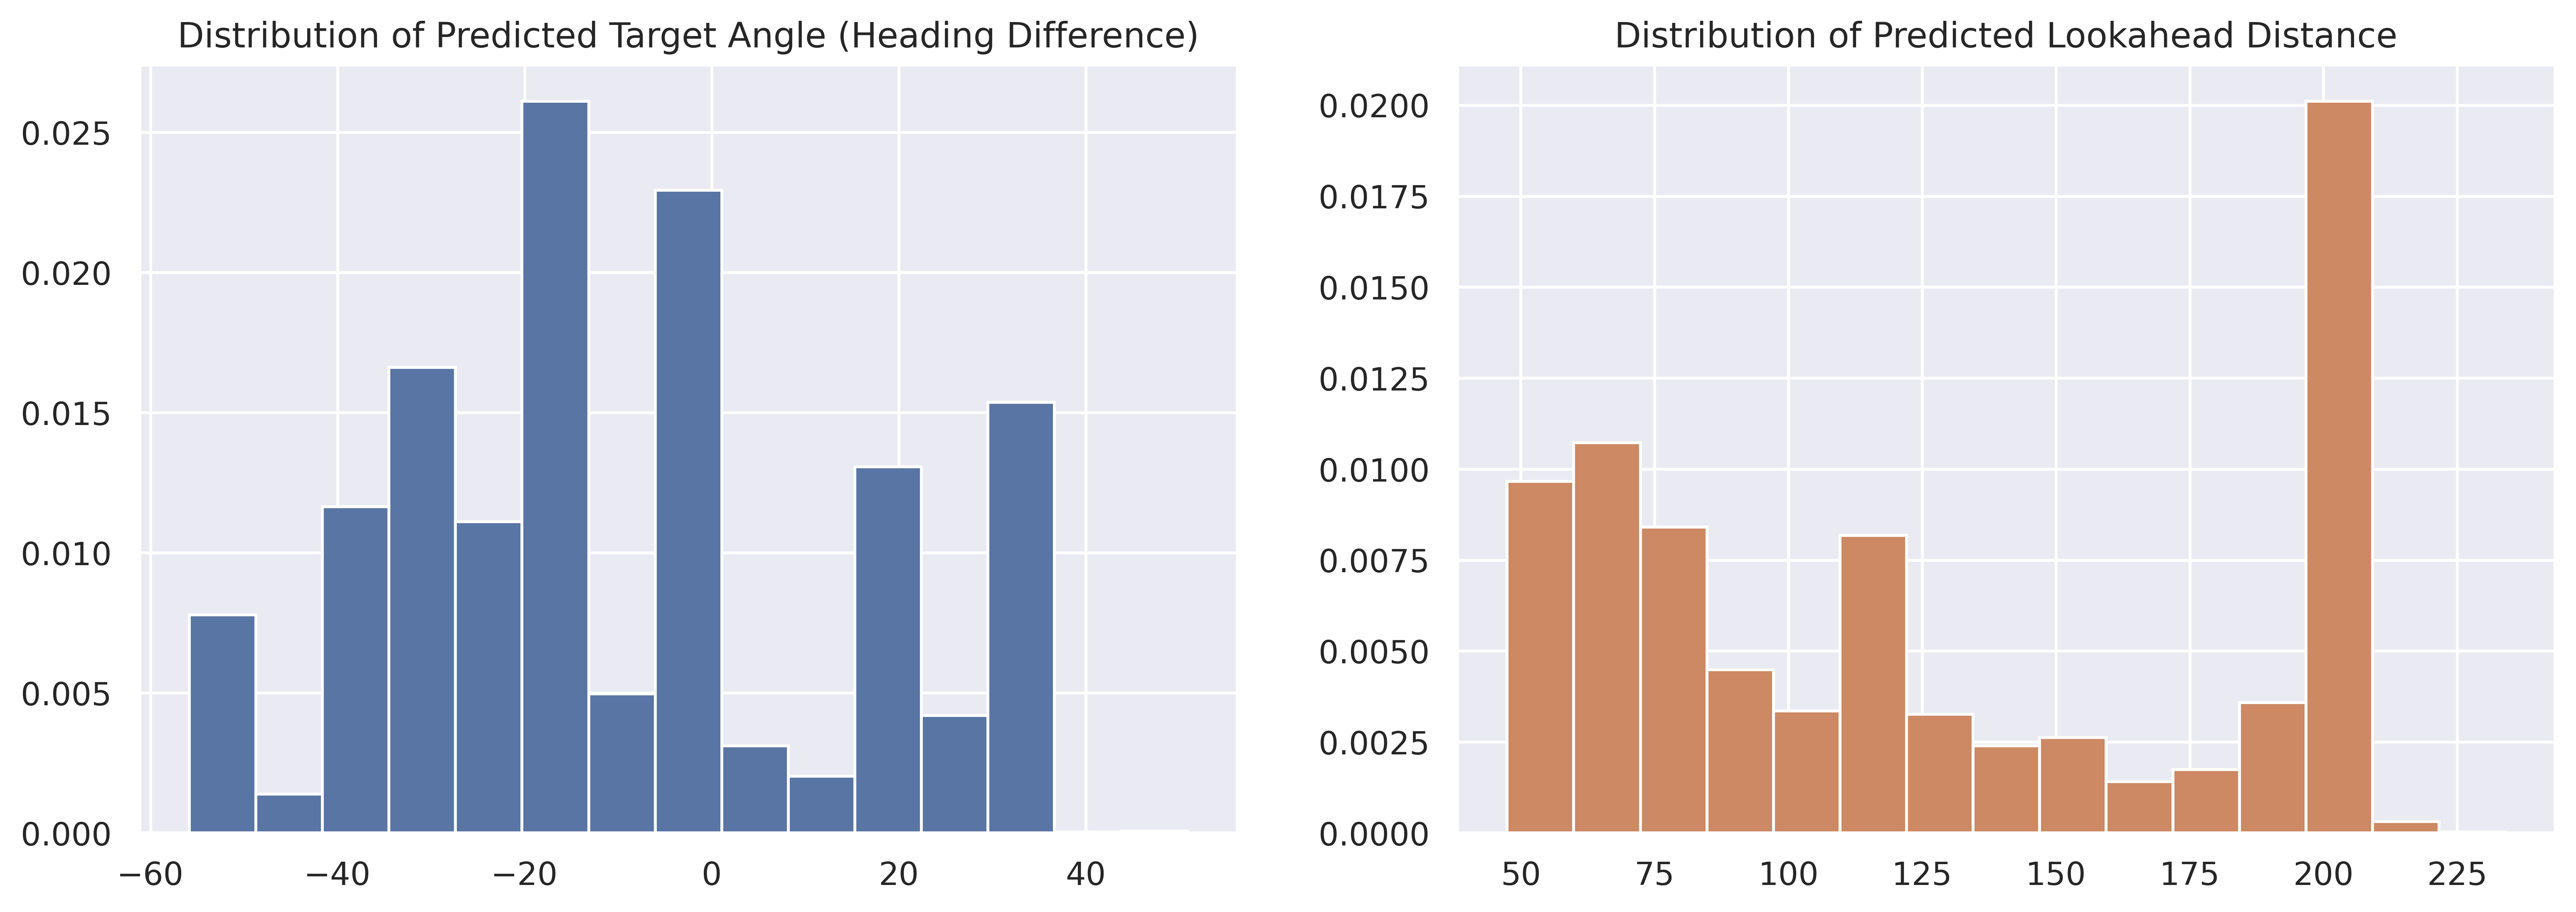

In [28]:
fig, ax = plt.subplots(ncols=2, dpi=500)
fig.set_figwidth(15)

ax[0].hist(preds[:, 0], bins=15, density=True, color='#5975A4')
ax[0].set_title("Distribution of Predicted Target Angle (Heading Difference)")

ax[1].hist(preds[:, 1], bins=15, density=True, color='#CC8963')
ax[1].set_title("Distribution of Predicted Lookahead Distance")

fig.savefig("pernn_angle_lookahead_phase1.png")

### Loading data files

In [29]:
X_train_traffic.iloc[:, :-2]=scaler.transform(X_train_traffic.iloc[:, :-2])
X_val_traffic.iloc[:, :-2]=scaler.transform(X_val_traffic.iloc[:, :-2])


Y_train_traffic=Y_train_traffic.values
Y_val_traffic=Y_val_traffic.values
print (X_train_traffic.shape)
print (Y_train_traffic.shape)
print (X_val_traffic.shape)
print (Y_val_traffic.shape)

(560927, 67)
(560927,)
(172832, 67)
(172832,)


In [30]:
np.max(X_train_traffic.iloc[:,-2])

90.0

In [31]:
X_train_traffic = pd.concat([X_train_traffic, X_train_empty]).reset_index(drop=True)
X_val_traffic = pd.concat([X_val_traffic, X_val_empty]).reset_index(drop=True)
Y_train_traffic = np.concatenate([Y_train_traffic, Y_train_empty])
Y_val_traffic = np.concatenate([Y_val_traffic, Y_val_empty])


### Collective Training

In [32]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_delta=0.0001, min_lr=0)

In [34]:
learning_rate=1e-3

input_c = Input(shape=(X_train_traffic.shape[1]-2,), name="input_c")
target_angle_lookahead = model_perception(input_c)

intermediate_from_p = model_perception.get_layer("dense_3").output

# Since intermediate_from_a is a layer, you can concatenate it with the other input
merge_layer = tf.keras.Model(input_p, intermediate_from_p)(input_c)


l1_c = Dense(8, activation="relu",kernel_initializer='he_normal', name='dense_c1')(merge_layer)
l2_c = Dense(4, activation="relu",kernel_initializer='he_normal', name='dense_c2')(l1_c)
residual = Dense(1,kernel_initializer='he_normal', name='residual')(l2_c)
# out_p = Lambda(compute_steering, name='pp_based_steering')([input_p[:,0:19], lookahead[:,0]])
steer = Lambda(compute_steering, name='pp_based_steering')(target_angle_lookahead)
steer = Add()([steer, residual])

model = tf.keras.Model(input_c, [steer, target_angle_lookahead])

model.compile(optimizer=Adam(learning_rate),loss='mean_absolute_error',metrics=['mae'],
             loss_weights=[1, 0])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_c (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 model_1 (Functional)           (None, 8)            1192        ['input_c[0][0]']                
                                                                                                  
 dense_c1 (Dense)               (None, 8)            72          ['model_1[0][0]']                
                                                                                                  
 model (Functional)             (None, 2)            1210        ['input_c[0][0]']                
                                                                                            

In [35]:
stats = model.fit(X_train_traffic.iloc[:,:-2],Y_train_traffic,validation_data=(X_val_traffic.iloc[:,:-2],Y_val_traffic),batch_size=512,epochs=50,callbacks=[reduce_lr])

Epoch 1/50
1429/1429 [==============================] - 5s 3ms/step - loss: 0.2641 - add_loss: 0.2641 - model_loss: 50.0100 - add_mae: 0.2641 - model_mae: 50.0100 - val_loss: 0.0567 - val_add_loss: 0.0567 - val_model_loss: 50.7835 - val_add_mae: 0.0567 - val_model_mae: 50.7835 - lr: 0.0010
Epoch 2/50
1429/1429 [==============================] - 4s 3ms/step - loss: 0.0764 - add_loss: 0.0764 - model_loss: 49.8144 - add_mae: 0.0764 - model_mae: 49.8144 - val_loss: 0.0440 - val_add_loss: 0.0440 - val_model_loss: 49.8068 - val_add_mae: 0.0440 - val_model_mae: 49.8068 - lr: 0.0010
Epoch 3/50
1429/1429 [==============================] - 4s 3ms/step - loss: 0.0663 - add_loss: 0.0663 - model_loss: 49.8005 - add_mae: 0.0663 - model_mae: 49.8005 - val_loss: 0.0394 - val_add_loss: 0.0394 - val_model_loss: 49.0416 - val_add_mae: 0.0394 - val_model_mae: 49.0416 - lr: 0.0010
Epoch 4/50
1429/1429 [==============================] - 4s 2ms/step - loss: 0.0602 - add_loss: 0.0602 - model_loss: 48.4913 - a

KeyboardInterrupt: 

In [36]:
steers, perc = model.predict(X_val_traffic.iloc[:,:-2])


9208/9208 [==============================] - 6s 652us/step


Text(0.5, 1.0, 'Distribution of Predicted Target Angle (Heading Difference)')

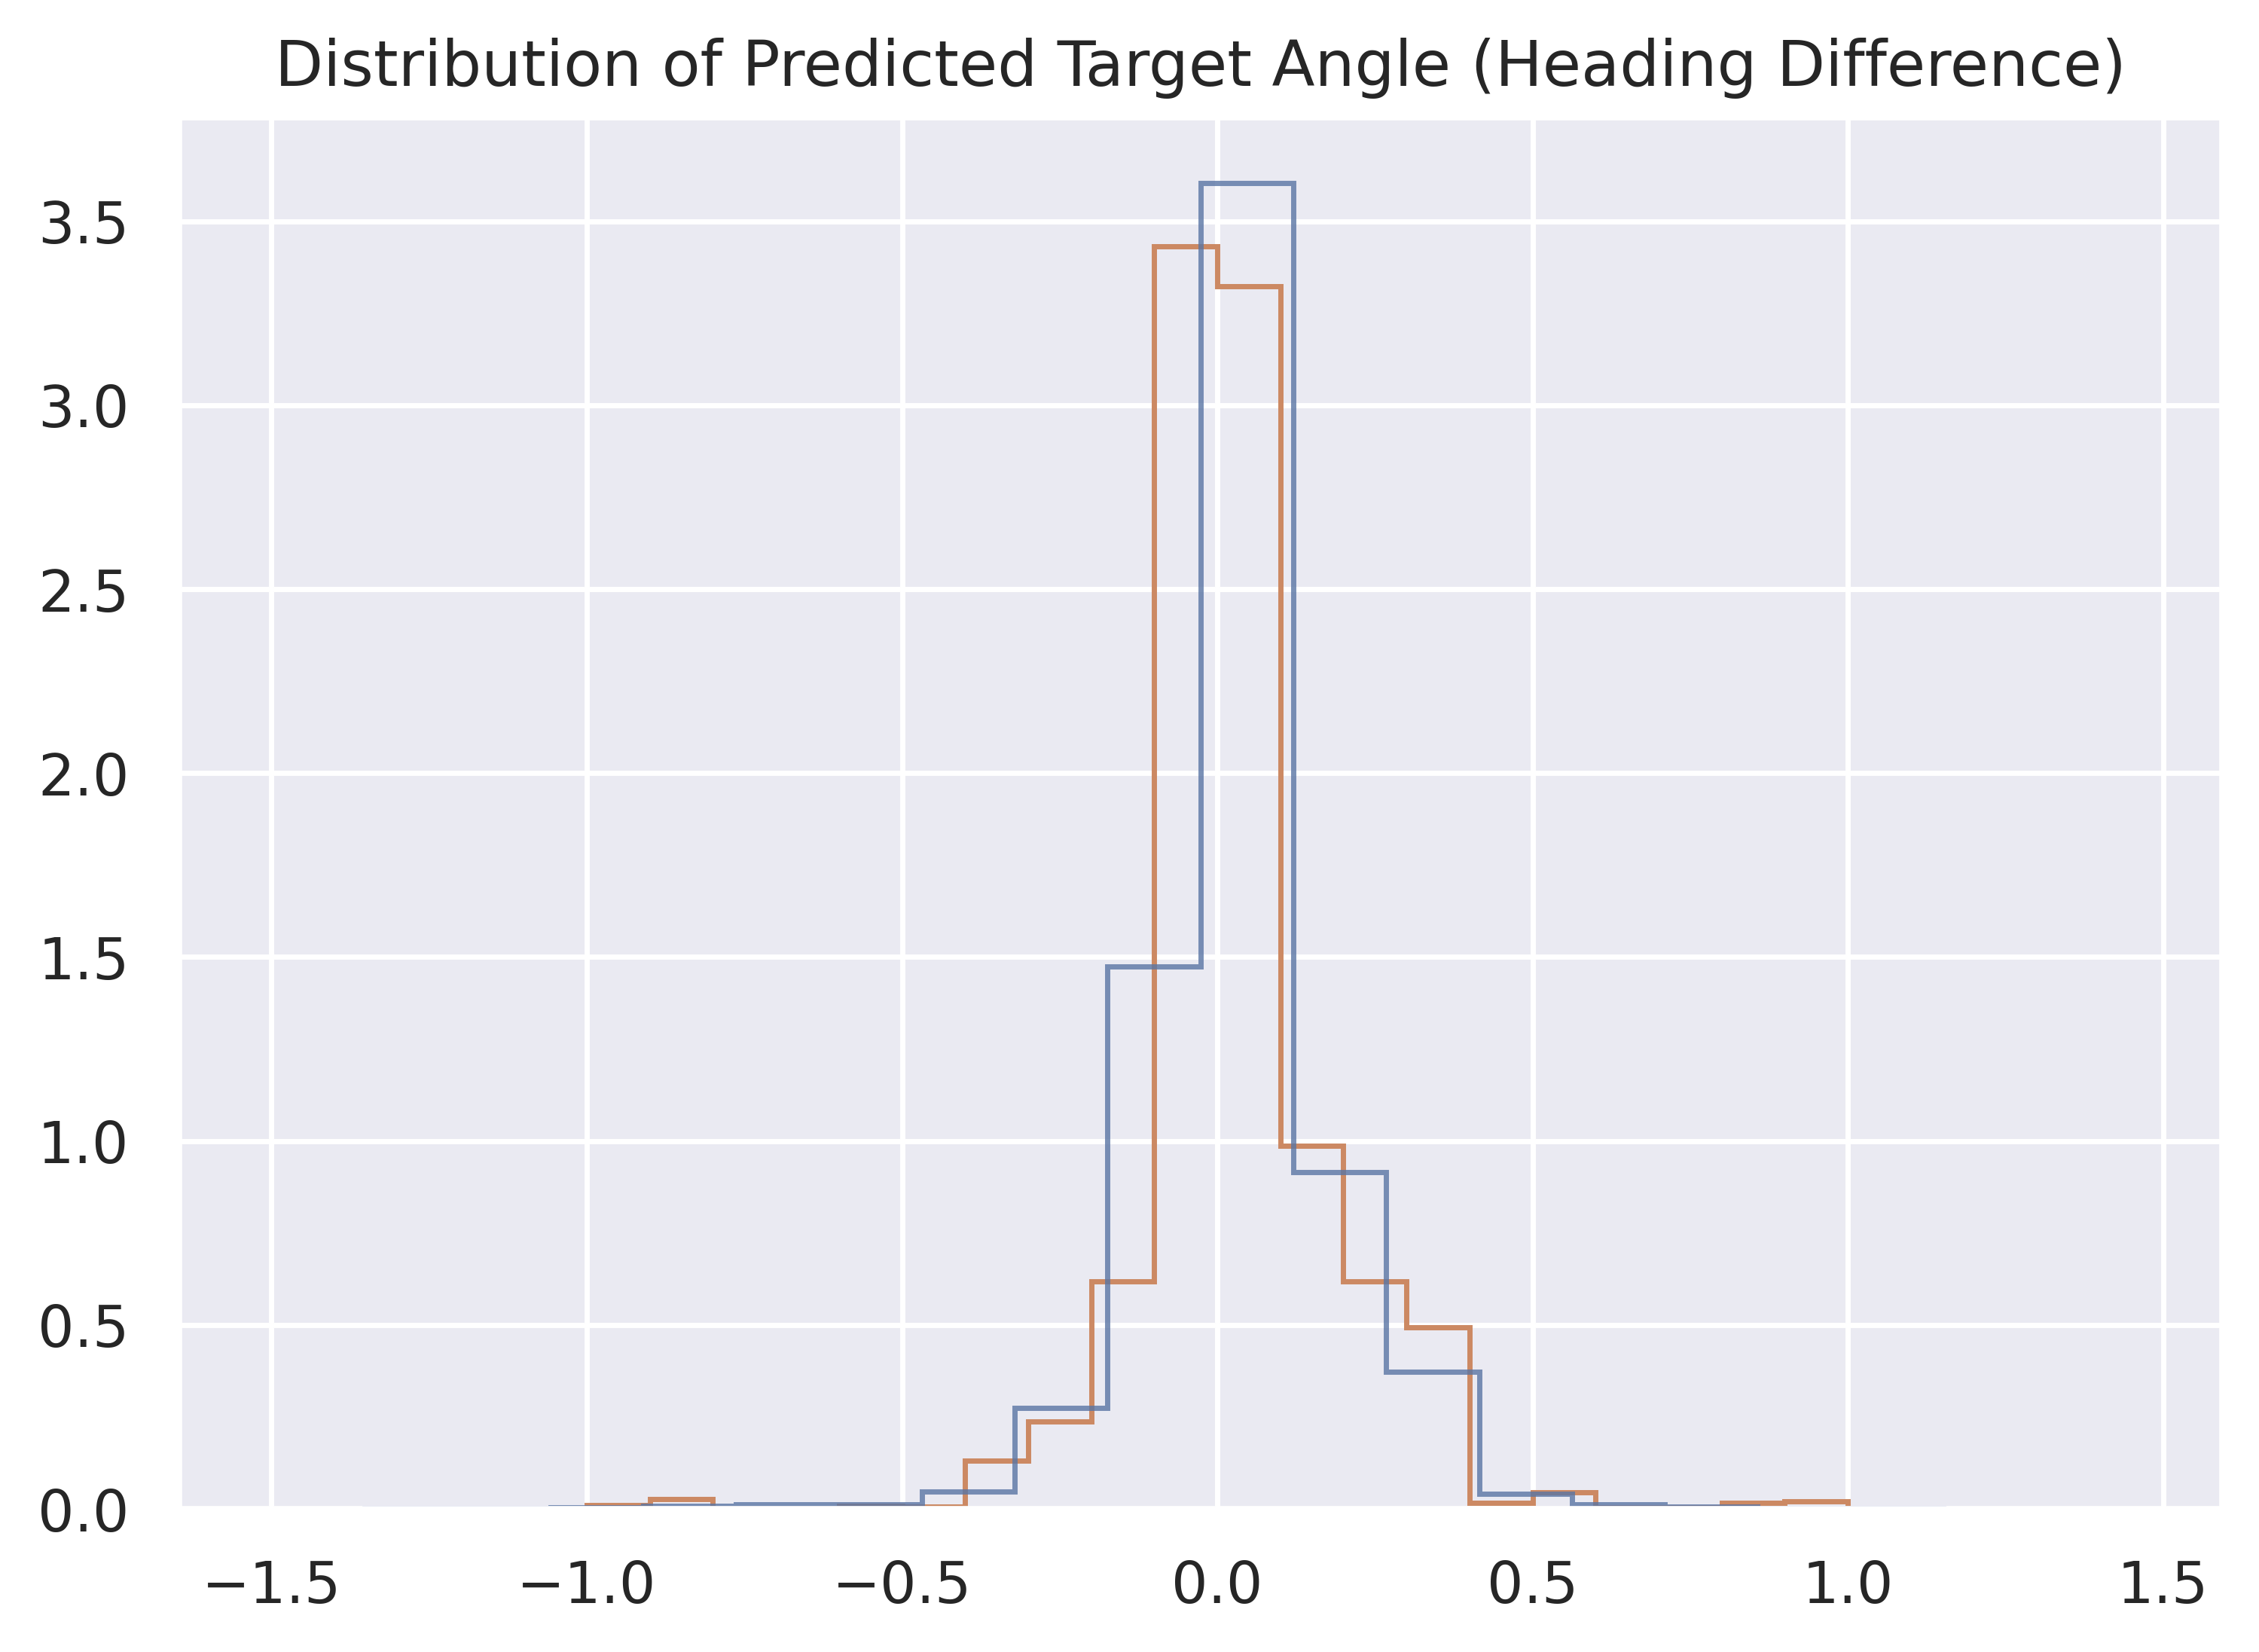

In [37]:
fig, ax = plt.subplots(dpi=500)
fig.set_figwidth(7)

#plt.hist()

ax.hist(Y_val_traffic, bins=20, density=True, color='#CC8963', histtype='step')
ax.hist(steers, bins=20, density=True, color='#5975A4', alpha=0.8, histtype='step')
ax.set_title("Distribution of Predicted Target Angle (Heading Difference)")

#fig.savefig("pernn_angle_lookahead_phase2.png")

In [38]:
model.save(MODEL_SAVE_DIR.joinpath('model.h5'))

model_perception.save(MODEL_SAVE_DIR.joinpath('model_perception.h5'))

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


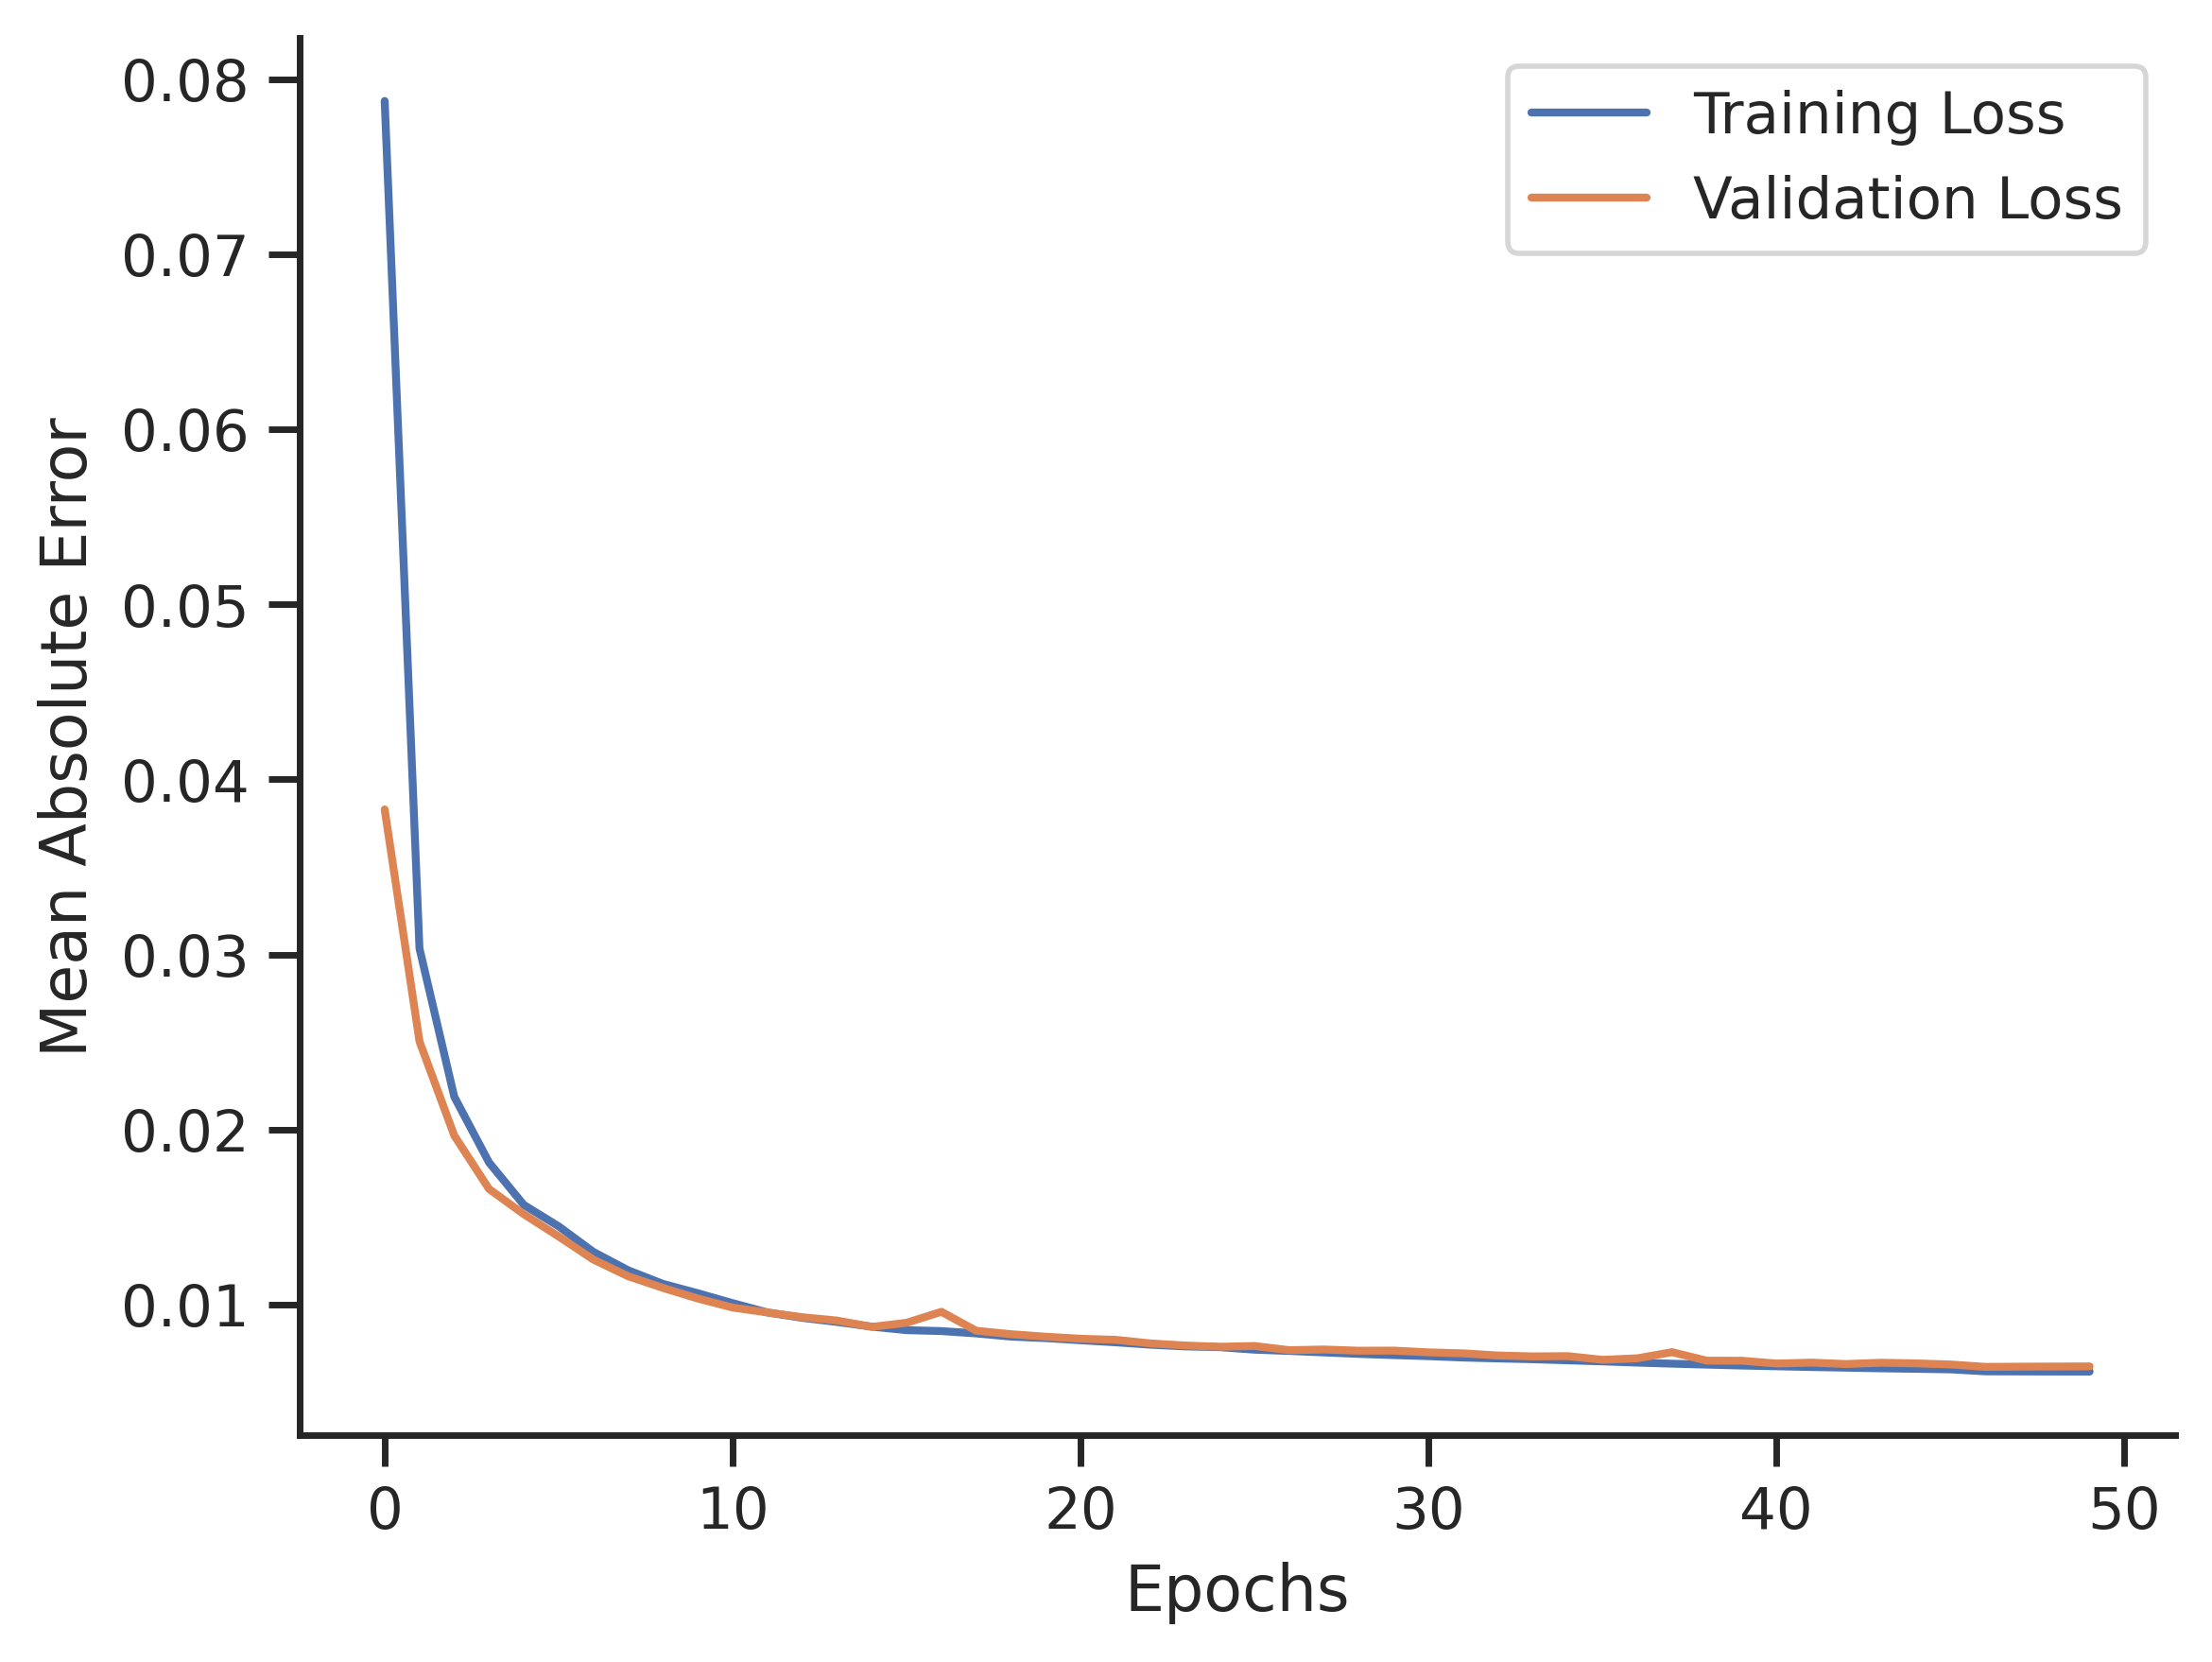

In [31]:
fig, ax = plt.subplots(dpi=400)
ax.plot(stats.history['loss'])
ax.plot(stats.history['val_loss'])
ax.legend(['Training Loss', 'Validation Loss'])
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Absolute Error")

fig.savefig("pi_loss.png")

In [32]:
preds = model.predict(X_val.iloc[:,:-2])


4314/4314 [==============================] - 2s 562us/step


(array([[ 1530.,  2639.,  4513.,  3077.,  6039., 38545., 47010.,  4574.,
         23376.,  6736.],
        [    0.,     0.,     0.,     0.,     0.,     0.,  3065., 75045.,
         59114.,   815.]]),
 array([-790.7022  , -676.90955 , -563.1169  , -449.32422 , -335.53156 ,
        -221.7389  , -107.94624 ,    5.846414,  119.63908 ,  233.43173 ,
         347.2244  ], dtype=float32),
 <a list of 2 BarContainer objects>)

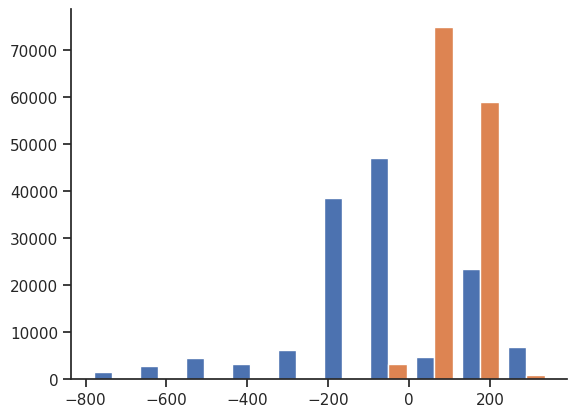

In [33]:
plt.hist(preds[1])

In [57]:
model = load_model("PI_model_new/model.h5", custom_objects={'compute_steering': compute_steering,
                                                               'compute_target_angle': compute_target_angle,
                                                               'get_max_dist_idx': get_max_dist_idx})

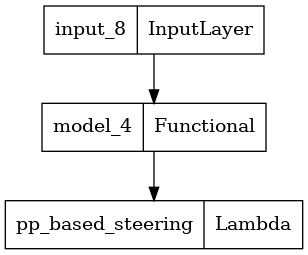

In [58]:
tf.keras.utils.plot_model(model)